<a href="https://colab.research.google.com/github/KamilBartosik/CNN_TrafficSignClassification/blob/main/CNN_TrafficSignClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamilbartosik","key":"60a7bc4864ce8f6cc1ed6c5660f37473"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


In [5]:
!kaggle datasets list -s gtsrb-german-traffic-sign

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34          66268        880  0.8235294        
valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11           8797        232  1.0              
eunjurho/german-traffic-sign-recognition-benchmark-cropped         german_traffic_sign_recognition_benchmark_cropped  206MB  2019-11-10 15:22:13            314          8  0.75             
bhavinmoriya/german-traffic-sign-recognition-bench

In [6]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
%cd ..

100% 611M/612M [00:02<00:00, 265MB/s]
100% 612M/612M [00:02<00:00, 247MB/s]
/content


In [ ]:
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip

In [8]:
!rm -rf traffic_sign_dataset/Meta
!rm -rf traffic_sign_dataset/meta
!rm -rf traffic_sign_dataset/test
!rm -rf traffic_sign_dataset/train
!rm traffic_sign_dataset/Meta.csv
!rm traffic_sign_dataset/Test/GT-final_test.csv

# Importing libraries

In [9]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Image preprocessing

## Check data and dimensions of images

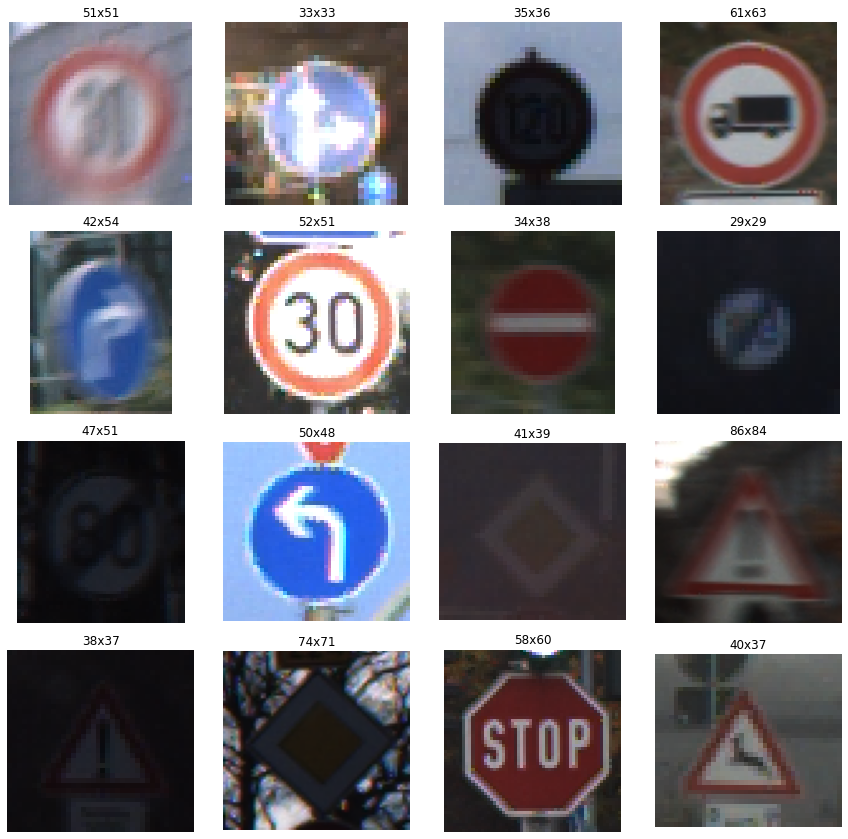

In [10]:
plt.figure(figsize=(12, 12))
path = "traffic_sign_dataset/Test"
for i in range(1, 17):
  plt.subplot(4, 4, i)
  plt.tight_layout()
  rand_img = imread(path + '/' + random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.axis('off')
  plt.title(f'{rand_img.shape[1]}x{rand_img.shape[0]}' )

In [11]:
# Check mean dimension of images
dim1 = []
dim2 = []

path_trainset = "traffic_sign_dataset/Train"
nb_classes = len(os.listdir(path_trainset))

for class_nb in range(nb_classes):
  labels = f"traffic_sign_dataset/Train/{class_nb}"
  img_path = os.listdir(labels)
  for image_nb in img_path:
    img = imread(labels + '/' + image_nb)
    dim1.append(img.shape[0])
    dim2.append(img.shape[1])

In [12]:
print("Mean dimension of images: ", np.around(np.mean(dim1), 1), "x", np.around(np.mean(dim2), 1))

Mean dimension of images:  50.3 x 50.8


## Image resize and normalization

In [13]:
images = []
label_id = []

for class_nb in range(nb_classes):
  labels = f"traffic_sign_dataset/Train/{class_nb}"
  img_path = os.listdir(labels)
  for image_nb in img_path:
    img = Image.open(labels + '/' + image_nb)
    img = img.resize((50, 50))
    img = np.array(img)
    images.append(img)
    label_id.append(class_nb)

In [14]:
images = np.array(images)
images = images/255
images.shape

(39209, 50, 50, 3)

In [15]:
label_id = np.array(label_id)
label_id.shape

(39209,)

## Preparing Train and Val sets

In [16]:
x_train, x_val, y_train, y_val = train_test_split(images, label_id, test_size = 0.2, random_state = 42)

In [17]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Model architecture and training

In [18]:
model = Sequential()

model.add(Conv2D(32, 3, input_shape=images.shape[1:], activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 64)       2

In [20]:
model_path = "content/gdrive/MyDrive/MachineLearning/Models/TrafficSignClassification"

checkpointer = ModelCheckpoint(filepath=f'{model_path}/model_1.hdf5',
                               monitor='accuracy', 
                               mode='max',
                               verbose=1,
                               save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               verbose=1,
                               patience=4)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=0.0001)

callbacks = [checkpointer, early_stopping, reduce_lr]

In [21]:
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/50
246/246 [==============================] - ETA: 0s - loss: 2.6280 - accuracy: 0.2994
Epoch 1: accuracy improved from -inf to 0.29939, saving model to content/gdrive/MyDrive/MachineLearning/Models/TrafficSignClassification/model_1.hdf5
246/246 [==============================] - 15s 23ms/step - loss: 2.6280 - accuracy: 0.2994 - val_loss: 17.7646 - val_accuracy: 0.1206 - lr: 0.0010
Epoch 2/50
245/246 [============================>.] - ETA: 0s - loss: 1.2693 - accuracy: 0.6020
Epoch 2: accuracy improved from 0.29939 to 0.60200, saving model to content/gdrive/MyDrive/MachineLearning/Models/TrafficSignClassification/model_1.hdf5
246/246 [==============================] - 5s 21ms/step - loss: 1.2692 - accuracy: 0.6020 - val_loss: 2.8201 - val_accuracy: 0.5471 - lr: 0.0010
Epoch 3/50
244/246 [============================>.] - ETA: 0s - loss: 0.8009 - accuracy: 0.7396
Epoch 3: accuracy improved from 0.60200 to 0.73973, saving model to content/gdrive/MyDrive/MachineLearning/Models/Tra

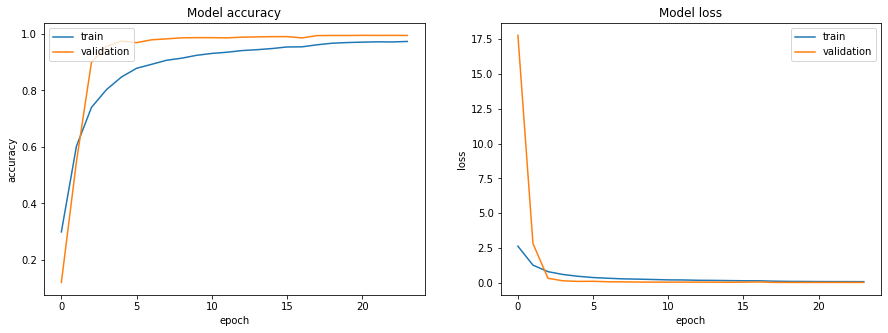

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Evaluations on the test set

In [23]:
test_path = "traffic_sign_dataset/Test"

In [24]:
x_test = []

for test_img in sorted(os.listdir(test_path)):
  img = Image.open(test_path + '/' + test_img)
  img = img.resize((50,50))
  img = np.array(img)
  x_test.append(img)

x_test = np.array(x_test)
x_test = x_test/255

In [25]:
test = pd.read_csv('traffic_sign_dataset/Test.csv')
y_test = test['ClassId'].values
y_test

array([16,  1, 38, ...,  6,  7, 10])

In [26]:
y_pred = np.argmax(model.predict(x_test), axis=1)
y_pred

395/395 [==============================] - 1s 3ms/step


array([16,  1, 38, ...,  5,  7, 10])

In [27]:
score = model.evaluate(x_test, y_test)

395/395 [==============================] - 2s 4ms/step - loss: 0.1382 - accuracy: 0.9677


In [28]:
all_labels = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)',
              'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)',
              'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 
              'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles',
              'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left',
              'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right',
              'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow',
              'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead',
              'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory',
              'End of passing', 'End of no passing by vehicles over 3.5 metric']

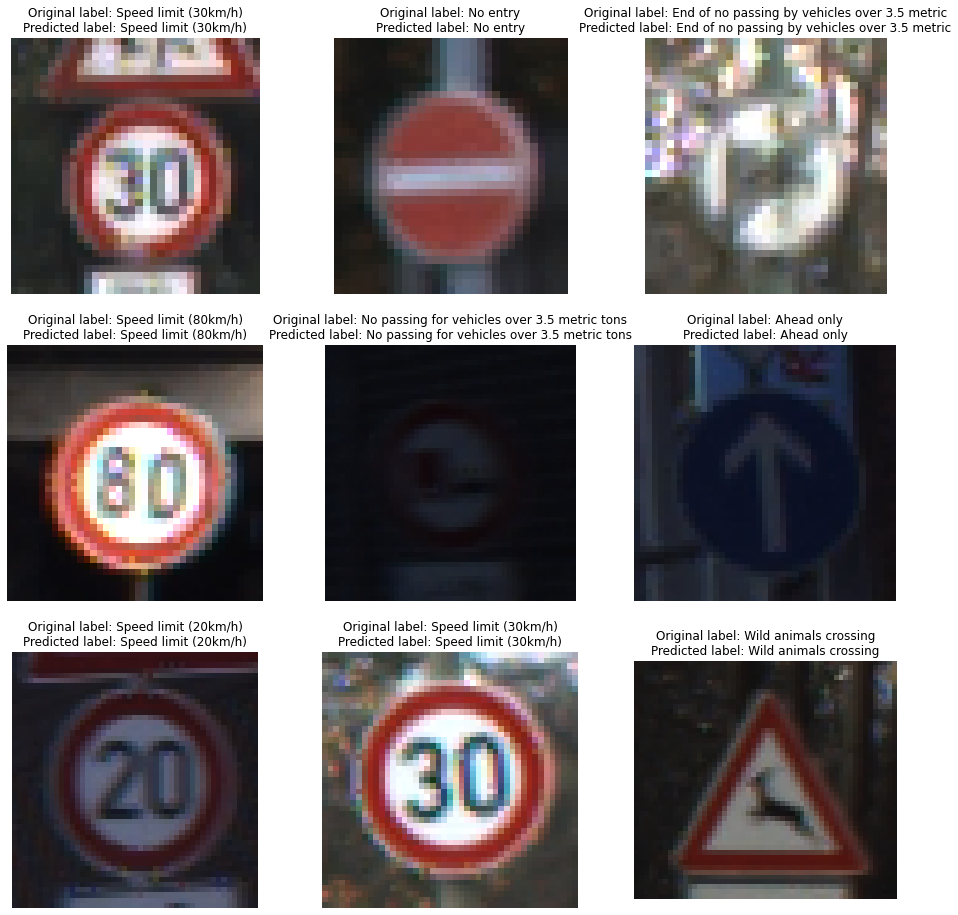

In [33]:
plt.figure(figsize=(16, 16))
for i in range(1, 10):
  plt.subplot(3, 3, i)
  
  test_img_names = sorted(os.listdir(test_path))
  rand_img = random.choice(test_img_names)
  idx = test_img_names.index(rand_img)
  rand_img_path = imread(test_path + '/' + rand_img)

  plt.imshow(rand_img_path)
  plt.axis('off')
  plt.title(f'Original label: {all_labels[y_test[idx]]}\nPredicted label: {all_labels[y_pred[idx]]}')